# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 967us/sample - loss: 236.3211 - y1_output_loss: 108.5853 - y2_output_loss: 125.4795 - y1_output_root_mean_squared_error: 10.4711 - y2_output_root_mean_squared_error: 11.2551 - val_loss: 31.7293 - val_y1_output_loss: 12.4668 - val_y2_output_loss: 18.6166 - val_y1_output_root_mean_squared_error: 3.5640 - val_y2_output_root_mean_squared_error: 4.3621
Epoch 2/500
614/614 [==============================] - 0s 136us/sample - loss: 34.4497 - y1_output_loss: 13.0081 - y2_output_loss: 21.1764 - y1_output_root_mean_squared_error: 3.6229 - y2_output_root_mean_squared_error: 4.6178 - val_loss: 23.0734 - val_y1_output_loss: 9.5626 - val_y2_output_loss: 13.5884 - val_y1_output_root_mean_squared_error: 3.0779 - val_y2_output_root_mean_squared_error: 3.6878
Epoch 3/500
614/614 [==============================] - 0s 131us/sample - loss: 25.9991 - y1_output_loss: 9.9686 - y2_output_loss: 16.0476 - y1_o

614/614 [==============================] - 0s 126us/sample - loss: 7.4624 - y1_output_loss: 2.6859 - y2_output_loss: 4.8049 - y1_output_root_mean_squared_error: 1.6380 - y2_output_root_mean_squared_error: 2.1862 - val_loss: 8.3730 - val_y1_output_loss: 2.7346 - val_y2_output_loss: 5.6868 - val_y1_output_root_mean_squared_error: 1.6266 - val_y2_output_root_mean_squared_error: 2.3931
Epoch 42/500
614/614 [==============================] - 0s 127us/sample - loss: 7.6875 - y1_output_loss: 2.6701 - y2_output_loss: 5.0878 - y1_output_root_mean_squared_error: 1.6374 - y2_output_root_mean_squared_error: 2.2375 - val_loss: 8.4690 - val_y1_output_loss: 2.7832 - val_y2_output_loss: 5.9590 - val_y1_output_root_mean_squared_error: 1.6134 - val_y2_output_root_mean_squared_error: 2.4219
Epoch 43/500
614/614 [==============================] - 0s 125us/sample - loss: 8.9996 - y1_output_loss: 3.0210 - y2_output_loss: 5.9754 - y1_output_root_mean_squared_error: 1.7433 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 124us/sample - loss: 6.3440 - y1_output_loss: 2.0426 - y2_output_loss: 4.2975 - y1_output_root_mean_squared_error: 1.4299 - y2_output_root_mean_squared_error: 2.0735 - val_loss: 18.6806 - val_y1_output_loss: 4.2358 - val_y2_output_loss: 13.8105 - val_y1_output_root_mean_squared_error: 2.0896 - val_y2_output_root_mean_squared_error: 3.7834
Epoch 63/500
614/614 [==============================] - 0s 128us/sample - loss: 7.1024 - y1_output_loss: 2.2442 - y2_output_loss: 4.7934 - y1_output_root_mean_squared_error: 1.5046 - y2_output_root_mean_squared_error: 2.1997 - val_loss: 6.4792 - val_y1_output_loss: 1.7699 - val_y2_output_loss: 4.7645 - val_y1_output_root_mean_squared_error: 1.2999 - val_y2_output_root_mean_squared_error: 2.1885
Epoch 64/500
614/614 [==============================] - 0s 127us/sample - loss: 6.1797 - y1_output_loss: 1.9875 - y2_output_loss: 4.2005 - y1_output_root_mean_squared_error: 1.4021 - y2_output_root_mean

Epoch 83/500
614/614 [==============================] - 0s 122us/sample - loss: 3.8001 - y1_output_loss: 0.9765 - y2_output_loss: 2.9089 - y1_output_root_mean_squared_error: 0.9874 - y2_output_root_mean_squared_error: 1.6808 - val_loss: 16.8216 - val_y1_output_loss: 3.0047 - val_y2_output_loss: 13.6517 - val_y1_output_root_mean_squared_error: 1.7376 - val_y2_output_root_mean_squared_error: 3.7152
Epoch 84/500
614/614 [==============================] - 0s 129us/sample - loss: 4.7297 - y1_output_loss: 1.2216 - y2_output_loss: 3.4991 - y1_output_root_mean_squared_error: 1.1006 - y2_output_root_mean_squared_error: 1.8757 - val_loss: 5.2143 - val_y1_output_loss: 1.1067 - val_y2_output_loss: 4.0381 - val_y1_output_root_mean_squared_error: 1.0364 - val_y2_output_root_mean_squared_error: 2.0347
Epoch 85/500
614/614 [==============================] - 0s 131us/sample - loss: 4.4614 - y1_output_loss: 1.0846 - y2_output_loss: 3.3372 - y1_output_root_mean_squared_error: 1.0457 - y2_output_root_mean

Epoch 104/500
614/614 [==============================] - 0s 127us/sample - loss: 3.5713 - y1_output_loss: 0.8183 - y2_output_loss: 2.7237 - y1_output_root_mean_squared_error: 0.9077 - y2_output_root_mean_squared_error: 1.6575 - val_loss: 3.0144 - val_y1_output_loss: 0.5045 - val_y2_output_loss: 2.4849 - val_y1_output_root_mean_squared_error: 0.7051 - val_y2_output_root_mean_squared_error: 1.5866
Epoch 105/500
614/614 [==============================] - 0s 123us/sample - loss: 2.3473 - y1_output_loss: 0.6056 - y2_output_loss: 1.7460 - y1_output_root_mean_squared_error: 0.7732 - y2_output_root_mean_squared_error: 1.3227 - val_loss: 3.0258 - val_y1_output_loss: 0.6705 - val_y2_output_loss: 2.3583 - val_y1_output_root_mean_squared_error: 0.8107 - val_y2_output_root_mean_squared_error: 1.5390
Epoch 106/500
614/614 [==============================] - 0s 122us/sample - loss: 2.2920 - y1_output_loss: 0.5990 - y2_output_loss: 1.7028 - y1_output_root_mean_squared_error: 0.7705 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 128us/sample - loss: 2.8023 - y1_output_loss: 0.6612 - y2_output_loss: 2.1278 - y1_output_root_mean_squared_error: 0.8167 - y2_output_root_mean_squared_error: 1.4613 - val_loss: 2.3332 - val_y1_output_loss: 0.4318 - val_y2_output_loss: 1.9042 - val_y1_output_root_mean_squared_error: 0.6582 - val_y2_output_root_mean_squared_error: 1.3784
Epoch 146/500
614/614 [==============================] - 0s 124us/sample - loss: 1.8492 - y1_output_loss: 0.4014 - y2_output_loss: 1.4576 - y1_output_root_mean_squared_error: 0.6325 - y2_output_root_mean_squared_error: 1.2038 - val_loss: 1.9395 - val_y1_output_loss: 0.3033 - val_y2_output_loss: 1.6271 - val_y1_output_root_mean_squared_error: 0.5507 - val_y2_output_root_mean_squared_error: 1.2792
Epoch 147/500
614/614 [==============================] - 0s 124us/sample - loss: 1.7929 - y1_output_loss: 0.3505 - y2_output_loss: 1.4297 - y1_output_root_mean_squared_error: 0.5939 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 125us/sample - loss: 1.6390 - y1_output_loss: 0.3484 - y2_output_loss: 1.3084 - y1_output_root_mean_squared_error: 0.5921 - y2_output_root_mean_squared_error: 1.1351 - val_loss: 3.6299 - val_y1_output_loss: 0.2786 - val_y2_output_loss: 3.2698 - val_y1_output_root_mean_squared_error: 0.5314 - val_y2_output_root_mean_squared_error: 1.8296
Epoch 187/500
614/614 [==============================] - 0s 124us/sample - loss: 1.5829 - y1_output_loss: 0.3543 - y2_output_loss: 1.2197 - y1_output_root_mean_squared_error: 0.5969 - y2_output_root_mean_squared_error: 1.1075 - val_loss: 2.5842 - val_y1_output_loss: 0.6356 - val_y2_output_loss: 1.9929 - val_y1_output_root_mean_squared_error: 0.7999 - val_y2_output_root_mean_squared_error: 1.3944
Epoch 188/500
614/614 [==============================] - 0s 124us/sample - loss: 1.3482 - y1_output_loss: 0.3320 - y2_output_loss: 1.0064 - y1_output_root_mean_squared_error: 0.5774 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 126us/sample - loss: 1.3760 - y1_output_loss: 0.3852 - y2_output_loss: 0.9820 - y1_output_root_mean_squared_error: 0.6229 - y2_output_root_mean_squared_error: 0.9940 - val_loss: 1.3861 - val_y1_output_loss: 0.2485 - val_y2_output_loss: 1.1418 - val_y1_output_root_mean_squared_error: 0.4999 - val_y2_output_root_mean_squared_error: 1.0659
Epoch 228/500
614/614 [==============================] - 0s 126us/sample - loss: 0.9816 - y1_output_loss: 0.2231 - y2_output_loss: 0.7545 - y1_output_root_mean_squared_error: 0.4720 - y2_output_root_mean_squared_error: 0.8711 - val_loss: 1.3446 - val_y1_output_loss: 0.2349 - val_y2_output_loss: 1.1231 - val_y1_output_root_mean_squared_error: 0.4841 - val_y2_output_root_mean_squared_error: 1.0536
Epoch 229/500
614/614 [==============================] - 0s 130us/sample - loss: 1.2296 - y1_output_loss: 0.3276 - y2_output_loss: 0.8940 - y1_output_root_mean_squared_error: 0.5746 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 127us/sample - loss: 0.7344 - y1_output_loss: 0.1999 - y2_output_loss: 0.5302 - y1_output_root_mean_squared_error: 0.4480 - y2_output_root_mean_squared_error: 0.7305 - val_loss: 1.1775 - val_y1_output_loss: 0.2799 - val_y2_output_loss: 0.9005 - val_y1_output_root_mean_squared_error: 0.5322 - val_y2_output_root_mean_squared_error: 0.9456
Epoch 269/500
614/614 [==============================] - 0s 125us/sample - loss: 0.7320 - y1_output_loss: 0.1941 - y2_output_loss: 0.5430 - y1_output_root_mean_squared_error: 0.4382 - y2_output_root_mean_squared_error: 0.7348 - val_loss: 1.2117 - val_y1_output_loss: 0.2488 - val_y2_output_loss: 0.9923 - val_y1_output_root_mean_squared_error: 0.5001 - val_y2_output_root_mean_squared_error: 0.9806
Epoch 270/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9228 - y1_output_loss: 0.2174 - y2_output_loss: 0.7084 - y1_output_root_mean_squared_error: 0.4622 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 126us/sample - loss: 0.6539 - y1_output_loss: 0.1555 - y2_output_loss: 0.4946 - y1_output_root_mean_squared_error: 0.3946 - y2_output_root_mean_squared_error: 0.7058 - val_loss: 1.1653 - val_y1_output_loss: 0.1949 - val_y2_output_loss: 0.9964 - val_y1_output_root_mean_squared_error: 0.4457 - val_y2_output_root_mean_squared_error: 0.9832
Epoch 310/500
614/614 [==============================] - 0s 126us/sample - loss: 0.6080 - y1_output_loss: 0.1833 - y2_output_loss: 0.4259 - y1_output_root_mean_squared_error: 0.4285 - y2_output_root_mean_squared_error: 0.6514 - val_loss: 1.6793 - val_y1_output_loss: 0.2558 - val_y2_output_loss: 1.3824 - val_y1_output_root_mean_squared_error: 0.5092 - val_y2_output_root_mean_squared_error: 1.1916
Epoch 311/500
614/614 [==============================] - 0s 122us/sample - loss: 0.8764 - y1_output_loss: 0.2034 - y2_output_loss: 0.6722 - y1_output_root_mean_squared_error: 0.4493 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 126us/sample - loss: 0.6076 - y1_output_loss: 0.1541 - y2_output_loss: 0.4571 - y1_output_root_mean_squared_error: 0.3912 - y2_output_root_mean_squared_error: 0.6742 - val_loss: 1.4266 - val_y1_output_loss: 0.2475 - val_y2_output_loss: 1.1522 - val_y1_output_root_mean_squared_error: 0.5027 - val_y2_output_root_mean_squared_error: 1.0835
Epoch 351/500
614/614 [==============================] - 0s 123us/sample - loss: 0.5625 - y1_output_loss: 0.1662 - y2_output_loss: 0.4195 - y1_output_root_mean_squared_error: 0.3999 - y2_output_root_mean_squared_error: 0.6345 - val_loss: 1.8408 - val_y1_output_loss: 0.4062 - val_y2_output_loss: 1.4475 - val_y1_output_root_mean_squared_error: 0.6433 - val_y2_output_root_mean_squared_error: 1.1945
Epoch 352/500
614/614 [==============================] - 0s 123us/sample - loss: 0.6480 - y1_output_loss: 0.1624 - y2_output_loss: 0.4882 - y1_output_root_mean_squared_error: 0.4028 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4594 - y1_output_loss: 0.1397 - y2_output_loss: 0.3197 - y1_output_root_mean_squared_error: 0.3747 - y2_output_root_mean_squared_error: 0.5648 - val_loss: 0.9564 - val_y1_output_loss: 0.1996 - val_y2_output_loss: 0.7412 - val_y1_output_root_mean_squared_error: 0.4515 - val_y2_output_root_mean_squared_error: 0.8675
Epoch 392/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4689 - y1_output_loss: 0.1375 - y2_output_loss: 0.3298 - y1_output_root_mean_squared_error: 0.3703 - y2_output_root_mean_squared_error: 0.5760 - val_loss: 0.9048 - val_y1_output_loss: 0.1898 - val_y2_output_loss: 0.7175 - val_y1_output_root_mean_squared_error: 0.4373 - val_y2_output_root_mean_squared_error: 0.8448
Epoch 393/500
614/614 [==============================] - 0s 120us/sample - loss: 0.4444 - y1_output_loss: 0.1291 - y2_output_loss: 0.3438 - y1_output_root_mean_squared_error: 0.3584 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 123us/sample - loss: 0.4384 - y1_output_loss: 0.1327 - y2_output_loss: 0.3035 - y1_output_root_mean_squared_error: 0.3651 - y2_output_root_mean_squared_error: 0.5523 - val_loss: 0.7721 - val_y1_output_loss: 0.2099 - val_y2_output_loss: 0.5547 - val_y1_output_root_mean_squared_error: 0.4618 - val_y2_output_root_mean_squared_error: 0.7475
Epoch 433/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4401 - y1_output_loss: 0.1253 - y2_output_loss: 0.3214 - y1_output_root_mean_squared_error: 0.3549 - y2_output_root_mean_squared_error: 0.5605 - val_loss: 1.1462 - val_y1_output_loss: 0.1961 - val_y2_output_loss: 0.9398 - val_y1_output_root_mean_squared_error: 0.4430 - val_y2_output_root_mean_squared_error: 0.9746
Epoch 434/500
614/614 [==============================] - 0s 129us/sample - loss: 0.5255 - y1_output_loss: 0.1502 - y2_output_loss: 0.3711 - y1_output_root_mean_squared_error: 0.3893 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 127us/sample - loss: 0.3675 - y1_output_loss: 0.1133 - y2_output_loss: 0.2516 - y1_output_root_mean_squared_error: 0.3380 - y2_output_root_mean_squared_error: 0.5032 - val_loss: 0.7342 - val_y1_output_loss: 0.2098 - val_y2_output_loss: 0.5360 - val_y1_output_root_mean_squared_error: 0.4590 - val_y2_output_root_mean_squared_error: 0.7235
Epoch 474/500
614/614 [==============================] - 0s 129us/sample - loss: 0.3721 - y1_output_loss: 0.1101 - y2_output_loss: 0.2597 - y1_output_root_mean_squared_error: 0.3319 - y2_output_root_mean_squared_error: 0.5118 - val_loss: 0.7199 - val_y1_output_loss: 0.2004 - val_y2_output_loss: 0.5222 - val_y1_output_root_mean_squared_error: 0.4471 - val_y2_output_root_mean_squared_error: 0.7211
Epoch 475/500
614/614 [==============================] - 0s 125us/sample - loss: 0.3719 - y1_output_loss: 0.1262 - y2_output_loss: 0.2451 - y1_output_root_mean_squared_error: 0.3560 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 30us/sample - loss: 1.1154 - y1_output_loss: 0.2890 - y2_output_loss: 0.8193 - y1_output_root_mean_squared_error: 0.5399 - y2_output_root_mean_squared_error: 0.9077
Loss = 1.115422751222338, Y1_loss = 0.28896015882492065, Y1_mse = 0.5398775935173035, Y2_loss = 0.8193337321281433, Y2_mse = 0.907719612121582


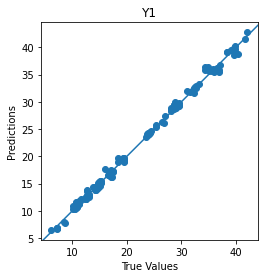

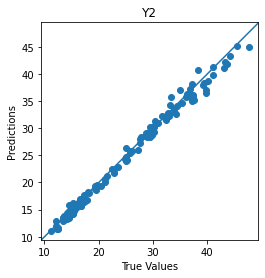

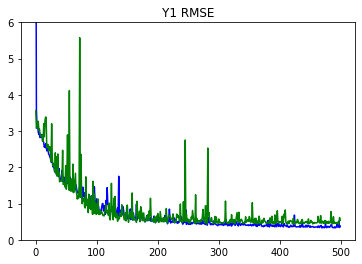

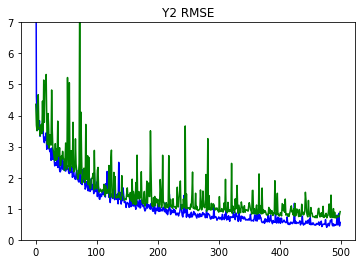

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)